In [1]:
import os
import cv2
from math import log10, sqrt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pylab import imshow, gray, show

In [2]:
# IGT Algorithm Class

class ImageBinarization:

    # Get the image name from path
    def get_image_name(self, img_path):
        return img_path.split('/')[-1]
        
    # Open image
    def open_image(self, image_path):
        img = Image.open(img_path).convert('L')
        return img
    # Convert image to numpy array
    def image_to_array(self, img):
        npimage = np.asarray(img)
        return npimage

    def process_image_global(self, npimage):
        npimage = npimage/255
        m, n = npimage.shape
        npimage_copy = npimage
        flag = True
        it_flag = True
        while 1:
            # Calculate mean of all pixels as threshold
            threshold = np.mean(npimage)
            if flag:
                old_threshold = threshold   # Will be used for termination condition
                flag = False
            
            # Subtract threshold from pixel
            npimage = (1 - threshold) + npimage
            for i in range(0, m):
                for j in range(0, n):
                    if npimage[i, j] > 1:
                        npimage[i, j] = 1
            
            # Hist equalization
            min_pixel_value = np.min(npimage)
            npimage = 1 - ((1 - npimage) / (1 - min_pixel_value))
            
            # Current image is old image for the next iteration
            npimage_copy = npimage
            old_threshold = threshold
            if it_flag  :
                it_flag = False
                continue
            count = 0
            
            # If the number of pixels transformed between 2 iterations < 3%, then we terminate
            for i in range(0, m):
                for j in range(0, n):
                    if npimage[i, j] > threshold and npimage_copy[i, j] <= old_threshold:
                        count += 1 
                    elif npimage[i, j] <= threshold and npimage_copy[i, j] > old_threshold:
                        count += 1
                        
            if count < (0.03 * m * n):
                break

        # If pixel is not already background(1), then convert to foreground(0)
        for i in range(0, m):
            for j in range(0, n):
                if npimage[i, j] == 1:
                    npimage[i, j] = 255
                else:
                    npimage[i, j] = 0
        
        return npimage

    # Driver function to run the whole process
    def driver_function(self, img_path):
        img = self.open_image(img_path)
        npimage = self.image_to_array(img)
        img_global = self.process_image_global(npimage)
        new_p = Image.fromarray(img_global)
        new_p = new_p.convert("L")
        img_name = self.get_image_name(img_path)
        output_path = '../quantitative_analysis/igt_results/' + img_name
        new_p.save(output_path)

In [3]:
# Run IGT algorithm for all images in the dataset
image_binarization = ImageBinarization()
for i in range(1, 6):
    img_path = "../quantitative_analysis/dataset/" + str(i) + ".bmp"
    image_binarization.driver_function(img_path)

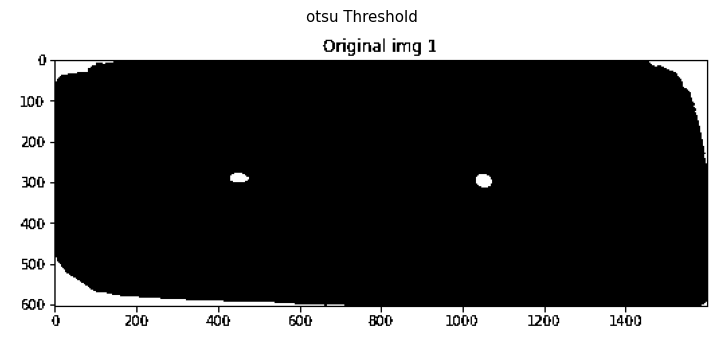

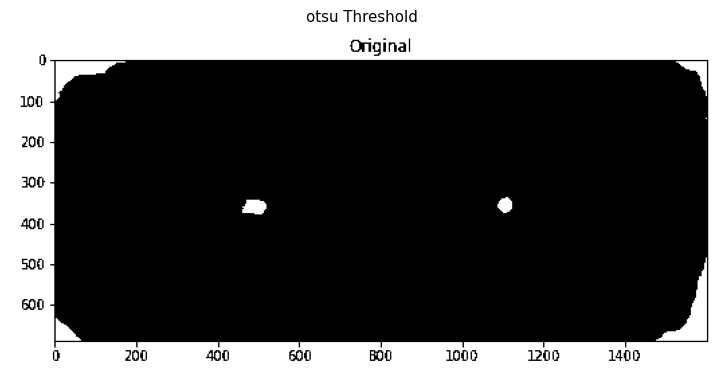

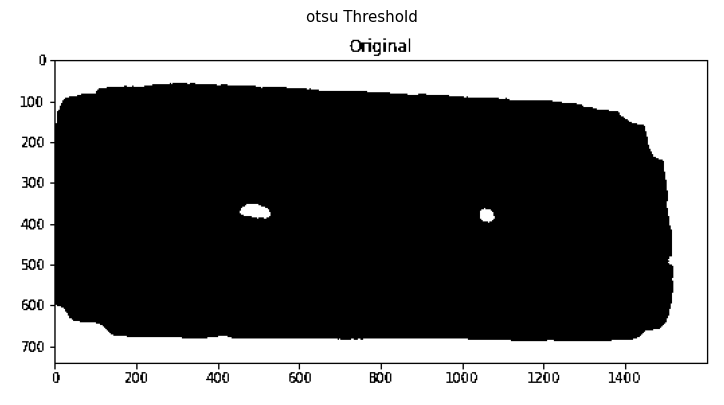

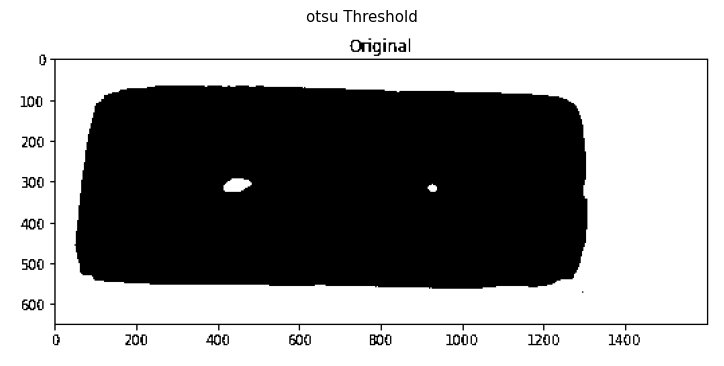

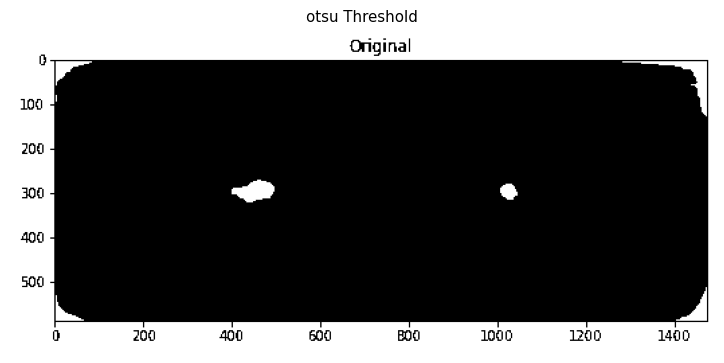

In [4]:
import matplotlib
import matplotlib.pyplot as plt

from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

def otsu_threshold(img_path):

    matplotlib.rcParams['font.size'] = 9

    img = Image.open(img_path).convert('L')
    npimage = np.asarray(img)
    image = npimage

    window_size = 15
    thresh_otsu = threshold_otsu(image)

    binary_otsu = image > thresh_otsu

    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 4)
    plt.imshow(binary_otsu, cmap=plt.cm.gray)
    plt.title('otsu Threshold')
    plt.axis('off')

    plt.show()
    
    final_otsu = Image.fromarray(binary_otsu)
    final_otsu = final_otsu.convert("L")
    img_name = img_path.split('/')[-1]
    output_path = '../quantitative_analysis/otsu_results/' + img_name
    final_otsu.save(output_path)
    
# Iterate through all images in the dataset and apply binarization
for i in range(1, 6):
    img_path = "../quantitative_analysis/dataset/" + str(i) + ".bmp"
    otsu_threshold(img_path)

In [5]:
# Find Mean Squared Error for every pair of images

# Arrays to hold all the MSE values for both algorithms
mse_igt_arr = []
mse_otsu_arr = []

for it in range(1, 11):
    img_path_gt = "../quantitative_analysis/ground_truths/" + str(it) + "_gt.bmp"
    img_path_igt = "../quantitative_analysis/igt_results/" + str(it) + ".bmp"
    img_path_otsu = "../quantitative_analysis/otsu_results/" + str(it) + ".bmp"
    
    # Open images
    img_gt = Image.open(img_path_gt).convert('L')
    img_igt = Image.open(img_path_igt).convert('L')
    img_otsu = Image.open(img_path_otsu).convert('L')
    
    # Convert to numpy array
    npimage_gt = np.asarray(img_gt)
    npimage_igt = np.asarray(img_igt)
    npimage_otsu = np.asarray(img_otsu)
    
    # Check if dimensions match
    assert npimage_gt.shape == npimage_igt.shape
    assert npimage_gt.shape == npimage_otsu.shape

    m, n = npimage_gt.shape
    print(m, n)
    
    # Image is in grayscale (0 - 255), first convert to binary (0 or 1)
    binimage_gt = np.zeros((m, n))
    binimage_igt = np.zeros((m, n))
    binimage_otsu = np.zeros((m, n))
    
    # MSE can be found in this loop itself but another loop is added to show clarity to the calculation
    for i in range(0, m):
        for j in range(0, n):
            if npimage_gt[i][j] == 255:
                binimage_gt[i][j] = 1
            if npimage_igt[i][j] == 255:
                binimage_igt[i][j] = 1
            if npimage_otsu[i][j] == 255:
                binimage_otsu[i][j] = 1
    
#     print(binimage_gt)
#     print(binimage_igt)
#     print(binimage_sauvola)

    mse_igt = 0
    mse_otsu = 0
    for i in range(0, m):
        for j in range(0, n):
            mse_igt += (binimage_igt[i][j] - binimage_gt[i][j])**2
            mse_otsu += (binimage_otsu[i][j] - binimage_gt[i][j])**2
    # Divide total by number of pixels
    mse_igt /= (m * n)
    mse_otsu /= (m * n)
    
    # Add values to array
    mse_igt_arr.append(mse_igt)
    mse_otsu_arr.append(mse_otsu)

230 525
256 525
272 525
243 525
241 525
788 1364
656 963
334 1782
302 1339
315 378


In [6]:
print(mse_igt_arr)
print(mse_otsu_arr)

[0.2719089026915114, 0.27360119047619047, 0.2178501400560224, 0.17789535567313344, 0.2741355463347165, 0.07691899757357429, 0.015080857584276778, 0.11255435257431265, 0.07669309408523708, 0.10089023263626438]
[0.31780538302277433, 0.2976190476190476, 0.21884453781512606, 0.17425827944346464, 0.30346571823750246, 0.01427385861232267, 0.03634950485018869, 0.11255435257431265, 0.021979435083016384, 0.10519862265894012]


In [7]:
def PSNR(ground_truth, binarized):
    mse = np.mean((ground_truth - binarized) ** 2)
    print(mse)
    
    # MSE is zero means no noise is present in the signal.
    # Therefore PSNR have no importance.
    if(mse == 0):
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

psnr_adaptive_arr = []
psnr_otsu_arr = []

for img in range(1, 11):
    img_path_gt = "../quantitative_analysis/ground_truths/" + str(img) + "_gt.bmp"
    img_path_adaptive = "../quantitative_analysis/adaptive_results/" + str(img) + ".bmp"
    img_path_otsu = "../quantitative_analysis/otsu_results/" + str(img) + ".bmp"
    
    ground_truth = cv2.imread(img_path_gt)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    
    adaptive = cv2.imread(img_path_adaptive)
    adaptive = cv2.cvtColor(adaptive, cv2.COLOR_BGR2GRAY)
    
    otsu = cv2.imread(img_path_otsu)
    otsu = cv2.cvtColor(otsu, cv2.COLOR_BGR2GRAY)
    
    m, n = ground_truth.shape
    
    # Image is in grayscale (0 - 255), first convert to binary (0 or 1)
    binimage_gt = np.zeros((m, n))
    binimage_adaptive = np.zeros((m, n))
    binimage_otsu = np.zeros((m, n))

    for i in range(0, m):
        for j in range(0, n):
            if ground_truth[i][j] == 255:
                binimage_gt[i][j] = 1
            if adaptive[i][j] == 255:
                binimage_adaptive[i][j] = 1
            if otsu[i][j] == 255:
                binimage_otsu[i][j] = 1
    
    # Get PSNR
    psnr_adaptive = PSNR(binimage_gt, binimage_adaptive)
    psnr_otsu = PSNR(binimage_gt, binimage_otsu)
    
    # Add values to array
    psnr_adaptive_arr.append(psnr_adaptive)
    psnr_otsu_arr.append(psnr_otsu)

0.28805797101449276
0.31780538302277433
0.2981770833333333
0.2976190476190476
0.23083333333333333
0.21884453781512606
0.1947403488144229
0.17425827944346464
0.29883422248567476
0.30346571823750246
0.09541677210950177
0.01427385861232267
0.17838531773168198
0.03634950485018869
0.14775331491898358
0.11255435257431265
0.12859255449109497
0.021979435083016384
0.15443856554967667
0.10519862265894012


In [8]:
print(psnr_adaptive_arr)
print(psnr_otsu_arr)

[5.4052010266376005, 5.255257376916241, 6.367014769831761, 7.105440564307559, 5.245696686182896, 10.203752794428151, 7.4864089374081395, 8.30462766725064, 8.907841763343605, 8.112442408264986]
[4.978387509383068, 5.263392773898441, 6.598642885589946, 7.5880657833074, 5.17890362978188, 18.454586094000366, 14.395015006865224, 9.486377057949065, 16.579834740363484, 9.779899462615369]
